In [569]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import itertools
from scipy.signal import savgol_filter
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter, laplace
from scipy import ndimage
#import cv2
from scipy import interpolate
from mpl_toolkits import mplot3d
from PIL import Image
%matplotlib inline
import IPython
import pickle
# from vtk.util import numpy_support
# import vtk
import pyvista as pv
import numpy as np
from scipy.interpolate import interpn

In [570]:
import plotly.graph_objects as go

In [571]:
def plot(traj_x,traj_y, traj_z, animation = True):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter3d(
            x=traj_x,
            y=traj_z,
            z=traj_y,
            mode='lines',
            line=dict(
                color='red',
                width = 7
            ),
            name='survey_interpolated'
        ),
    )
    fig.update_layout(scene = dict(
                  #  xaxis_title='X AXIS TITLE',
                    yaxis_title='Drilling direction',
                    zaxis_title='True vertical depth (TVD)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

    fig.update_scenes(zaxis_autorange="reversed")
    fig.show()
    

# Points

- увеличить окрестность рассмотрения

- добавить просчет окончания

## 3D dataset

In [572]:
all_candidates = []
items = [[-1,1], [-1, -1], [-1,0], [0,0], [0, -1], [0,1], [1,1], [1,0], [1,-1]]
for item in itertools.product(items, repeat=3):
            all_candidates.append(list(item))

In [573]:
# import 3d cube
file = open("3D_301.833.2055.pickle",'rb')
cube_3d = pickle.load(file)

In [574]:
volume_cut= cube_3d[:,0::3,0::4]
volume_cut.shape

(301, 278, 514)

In [575]:
# grid.spacing = (80/len(volume_cut[:,0,0]), 80/len(volume_cut[0,:,0]), 230/len(volume_cut[0,0,:]))

# Greedy algorithm for 3D resistivity space

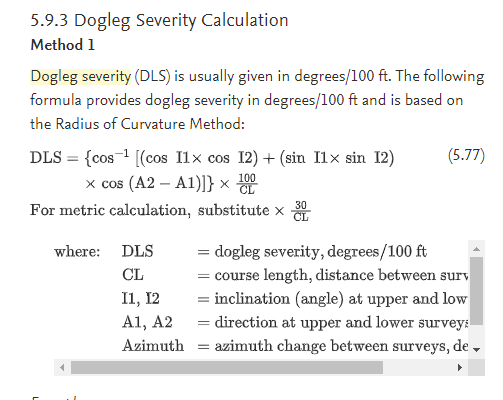

In [19]:
class Greedy_3d:
    def __init__(self, map_3d, n_steps_ahead, angle_constraint, step_z=1):
        self.map_3d = map_3d
        self.n_steps = n_steps_ahead
        self.angle_constraint = angle_constraint
        self.step_z = step_z
        self.step_x = 1
        self.step_y = 1

    def get_dogleg(self, inc1, azi1, inc2, azi2):
        dogleg = (
                2 * np.arcsin(
            (
                    np.sin((inc2 - inc1) / 2) ** 2
                    + np.sin(inc1) * np.sin(inc2)
                    * np.sin((azi2 - azi1) / 2) ** 2
            ) ** 0.5
        )
        )

        return dogleg

    def _get_angles(self, traj_x, traj_y, traj_z):
        xy = traj_x ** 2 + traj_y ** 2
        inc = np.arctan2(np.sqrt(xy), traj_z)  # for elevation angle defined from Z-axis down
        azi = (np.arctan2(traj_x, traj_y) + (2 * np.pi)) % (2 * np.pi)

        return np.stack((inc, azi), axis=1)

    def traj_planning(self, start_point, items, step_back=1):
        # traj = np.zeros_like(self.map_3d)

        # traj[start_point[0], start_point[1], start_point[2]] = 1
        OFV = 0
        k = 0
        next_point = start_point
        all_candidates = []
        traj_x = [start_point[0]]
        traj_y = [start_point[1]]
        traj_z = [start_point[2]]
        greedy_simple = False

        for item in itertools.product(items, repeat=self.n_steps):
            all_candidates.append(list(item))

        for z in range(0, self.map_3d.shape[2] - self.n_steps - start_point[2]):
            best_candidate = all_candidates[0]
            cand_point = next_point
            OFV_best = 0

            if cand_point[0] < (self.map_3d.shape[0] - self.n_steps) and \
                    (cand_point[1] < self.map_3d.shape[1] - self.n_steps):
                for l in range(0, len(all_candidates)):
                    #   obtain OFV of all possible candidates
                    OFV = 0
                    cand_point = next_point
                    for v in range(0, len(all_candidates[1])):

                        cand_point = [cand_point[0] + all_candidates[l][v][0],
                                      cand_point[1] + all_candidates[l][v][1], cand_point[2] + 1]
                        if l == 0:

                            OFV_best += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]
                        else:
                            OFV += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]

                    if OFV > OFV_best:
                        best_candidate = all_candidates[l]
                        OFV_best = OFV
            # angle constraint based on dogleg severity
            # прирост углов между локальнымил линейными приближениями, нормированные по приросту длины

            # linear approximation

            #  Calculate DogLeg
            if z >= step_back + 2:
                #                 az1 = np.arccos((traj_x[-1] - traj_x[-2])/ self.step_z)
                #                 az2 = np.arccos((traj_x[-1 - step_back] - traj_x[-2 - step_back])/ self.step_z)
                #                 incl1 = np.arccos((traj_y[-1] - traj_y[-2])/ self.step_z)
                #                 incl2 = np.arccos((traj_y[-1 - step_back] - traj_y[-2 - step_back])/ self.step_z)

                #                 d_incl = (incl1 - incl2)
                #                 d_az = (az1 - az2)

                traj_x_array, traj_y_array, traj_z_array = np.stack([traj_x, traj_y, traj_z])

                angles = self._get_angles(traj_x_array, traj_y_array, traj_z_array)

                incl1, az1 = angles[-1]

                incl2, az2 = angles[-step_back - 1]

                print('dincl1', np.degrees(incl2-incl1), '\n daz', np.degrees(az2-az1))
                dogleg = self.get_dogleg(incl1, az1, incl2, az2)

                if np.degrees(dogleg) >= self.angle_constraint:
                    next_step = [dx, dy, self.step_z]
                    k = 1
            #     traj_y_targ = self.step_z*np.cos(self.angle_constraint+incl2)+traj_y[-2] #corrected y_target based on the restriction of dogleg
            # also possible is to do search on a half-sphere via the scipy optimize framework, but it needs to be restructured for your
            # problem (I had a distinct target endpoint)
            # here you could define the cost function based on your oil saturation
            # and regularise with softplus (ln(1+e^kx); smooth approximation of ReLU) of dogleg shifted to the maximum tolerance point

            if not greedy_simple and k != 1:
                next_step = [best_candidate[0][0], best_candidate[0][1], self.step_z]

            # upper boundary x,y constraint
            if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                    next_step = [-self.step_x, - self.step_x, self.step_z]
                elif next_point[1] <= self.step_z:
                    next_step = [-self.step_x, 0, self.step_z]
                else:
                    next_step = [0, 0, self.step_z]

                    # lower boundary x,x constraint
            if next_point[0] <= self.step_z:
                if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                    next_step = [0, - self.step_x, self.step_z]
                elif next_point[1] <= self.step_z:
                    next_step = [0, 0, self.step_z]
                else:
                    next_step = [0, 0, self.step_z]

                # upper boundary y,x constraint
            if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                    next_step = [-self.step_x, - self.step_x, self.step_z]
                else:
                    next_step = [0, - self.step_x, self.step_z]

                # lower boundary y,x constraint
            if next_point[1] <= self.step_z:
                if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                    next_step = [-self.step_x, 0, self.step_z]
                else:
                    # next_point[0] <= self.step_z:
                    next_step = [0, 0, self.step_z]

            # print(next_point, next_step)

            next_point = [next_point[0] + next_step[0], next_point[1] + next_step[1], next_point[2] + next_step[2]]

            if z > 1:
                dx = next_point[0] - next_point_prev[0]
                dy = next_point[1] - next_point_prev[1]

            OFV += self.map_3d[next_point[0], next_point[1], next_point[2]]
            next_point_prev = next_point
            traj_x.append(next_point[0])
            traj_y.append(next_point[1])
            traj_z.append(next_point[2])

        print('OFV =', np.round(OFV, 2))
        return np.stack([traj_x, traj_y, traj_z])

    @staticmethod
    def trajectory_visualization(traj_x, traj_y, traj_z, color = 'red', width = 7):
        fig = go.Figure()

        fig.add_trace(
            go.Scatter3d(
                x=traj_x,
                y=traj_z,
                z=traj_y,
                mode='lines',
                line=dict(
                    color= color,
                    width= width
                ),
                name='survey_interpolated'
            ),
        )
        fig.update_layout(scene=dict(
            #  xaxis_title='X AXIS TITLE',
            yaxis_title='Drilling direction',
            zaxis_title='True vertical depth (TVD)'),
            width=700,
            margin=dict(r=20, b=10, l=10, t=10))

        fig.update_scenes(zaxis_autorange="reversed")
        fig.show()

In [55]:
class greedy_geosteering_advanced:
    def __init__(self, map_3d, items, step_z = 1, angle_constraint = 3, steps_ahead = 3, min_azimut = 0, max_azimut = 360,
                 min_zenith = 80, max_zenith = 91):
        self.map_3d = map_3d
        self.items = items
        self.step_z = step_z
        self.min_zenith = min_zenith
        self.max_zenith = max_zenith
        self.min_azimut = min_azimut
        self.max_azimut = max_azimut
        self.angle_constraint = angle_constraint
        self.steps_ahead = steps_ahead
        
    def get_dogleg(self, inc1, azi1, inc2, azi2):
        dogleg = (
        2 * np.arcsin(
            (
                np.sin((inc2 - inc1) / 2) ** 2
                + np.sin(inc1) * np.sin(inc2)
                * np.sin((azi2 - azi1) / 2) ** 2
            ) ** 0.5
        )
    )
        return dogleg
    
    def _get_angles(self, traj_x, traj_y, traj_z):
        xz = traj_x ** 2 + traj_z ** 2
        inc = np.arctan2(np.sqrt(xz), traj_y)  # for elevation angle defined from y-axis down
        azi = (np.arctan2(traj_x, traj_z) + (2 * np.pi)) % (2 * np.pi)

        return np.stack((inc, azi), axis=1)
    
    def get_best_candidate(self, current_point):
        all_candidates = []
        
        for item in itertools.product(items, repeat = self.steps_ahead):
            all_candidates.append(list(item))
        
        best_candidate = all_candidates[0]
        cand_point = current_point
        OFV_best = 0
                        
        if cand_point[0] < (self.map_3d.shape[0] - self.steps_ahead) and \
            (cand_point[1] < self.map_3d.shape[1] - self.steps_ahead) and (cand_point[2] < self.map_3d.shape[2] - self.step_z - self.steps_ahead):
                for l in range(0, len(all_candidates)):
                     #   obtain OFV of all possible candidates
                        OFV = 0
                        cand_point = current_point
                        for v in range(0, len(all_candidates[1])):

                            cand_point = [cand_point[0] + all_candidates[l][v][0] , 
                                          cand_point[1] + all_candidates[l][v][1], cand_point[2] + 1]
                            if l == 0:
                                OFV_best += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]
                            else:
                                OFV += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]

                        if OFV > OFV_best:
                            best_candidate = all_candidates[l]
                            OFV_best = OFV
        return best_candidate
    
    def get_next_step(self, traj_x, traj_y, traj_z, z, dx = 0, dy = 0, step_back = 1):
        k = 0
        next_point = [traj_x[-1], traj_y[-1], traj_z[-1]]
        
        traj_x_array, traj_y_array, traj_z_array = np.stack([traj_x, traj_y, traj_z])
        angles = self._get_angles(traj_x_array, traj_y_array, traj_z_array)
        
        best_candidate = self.get_best_candidate(next_point)
        #  Calculate DogLeg
        if z >= step_back :  
            incl2, az2 = angles[-step_back - 1]
        elif z >= 1 and z < step_back:
            incl2, az2 = angles[-1 - 1]

        incl1, az1 = angles[-1]

        if z > 1:
            dogleg = self.get_dogleg(incl1, az1, incl2, az2)
            print(z, np.degrees(incl2), np.degrees(dogleg), (np.degrees(az1)))

            if np.degrees(dogleg) >= self.angle_constraint:
                next_step = [dx, dy, self.step_z]
                k = 1
            if (np.degrees(incl2) <= 80) or (np.degrees(incl2) >= 95):
                next_step = [0, 0, self.step_z]
                k = 1

        if k != 1:
                print("best_cand")
                next_step = [best_candidate[0][0], best_candidate[0][1], self.step_z]
                
        # upper boundary x,y constraint
        if next_point[0] >= self.map_3d.shape[0] - self.step_z:
            if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                next_step = [-self.step_x, - self.step_x, self.step_z]
            elif next_point[1] <= self.step_z:
                next_step = [-self.step_x, 0, self.step_z]
            else:
                next_step = [0, 0, self.step_z]
               
           
        # lower boundary x,x constraint
        if next_point[0] <= self.step_z:
            if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                next_step = [0, - self.step_x, self.step_z]
            elif next_point[1] <= self.step_z:
                next_step = [0, 0, self.step_z]
            else:
                next_step = [0, 0, self.step_z]
                    
                       
        # upper boundary y,x constraint
        if next_point[1] >= self.map_3d.shape[1] - self.step_z:       
            if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                next_step = [-self.step_x, - self.step_x, self.step_z] 
            else: 
                next_step = [0, - self.step_x, self.step_z]
                 
            # lower boundary y,x constraint
        if next_point[1] <= self.step_z:
            if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                next_step = [-self.step_x, 0, self.step_z]
            else:
                next_step = [0, 0, self.step_z]
                
        return next_step
                
            
    def traj_planning(self, start_point, step_back = 10):
        OFV = 0
        next_point = start_point
        traj_x = [start_point[0]]
        traj_y = [start_point[1]]
        traj_z = [start_point[2]]
        greedy_simple = False
        dx = 0
        dy = 0
        
        
        for z in range(0, self.map_3d.shape[2] - self.steps_ahead - start_point[2] - self.step_z, self.step_z):
            next_step = self.get_next_step(traj_x, traj_y, traj_z, dx = 0, dy = 0, z = z, step_back = step_back)
            
            next_point = [next_point[0] + next_step[0], next_point[1] + next_step[1], next_point[2] + next_step[2]] 
           
            
            
            if z > 0:
                dx = next_point[0] - next_point_prev[0] 
                dy = next_point[1] - next_point_prev[1]
            OFV += self.map_3d[next_point[0], next_point[1], next_point[2]]
            next_point_prev = next_point
            traj_x.append(next_point[0])
            traj_y.append(next_point[1])
            traj_z.append(next_point[2])
            
           
        print('OFV =', np.round(OFV, 2))
        return np.stack([traj_x, traj_y, traj_z])
        
        
        
    
    
    

$$r = argmax\int_a^b Sdr$$
$$\partial^2_{x_ix_j}S=\partial_{x_i}S_j$$

In [528]:
class greedy_geosteering_polar:
    def __init__(self, map_3d, length = 10, angle_constraint = 3, steps_ahead = 3, start_point = [30,30,20],
                 init_inclination = 90, init_azimut = 0,
                 step_incl = 0.5, step_azi = 0.5,
                 min_azimut = 0, max_azimut = 90,
                 min_zenith = 80, max_zenith = 92):
        self.map_3d = map_3d
        
        self.length = length
        self.min_zenith = min_zenith
        self.max_zenith = max_zenith
        self.min_azimut = min_azimut
        self.max_azimut = max_azimut
        self.angle_constraint = angle_constraint
        self.steps_ahead = steps_ahead
        
        self.traj_x = [start_point[0]]
        self.traj_y = [start_point[2]]
        self.traj_z = [start_point[1]]
        
        self.incl_l = [init_inclination]
        self.azi_l = [init_azimut]
        
        self.step_incl = step_incl
        self.step_azi = step_azi
        
        
        self.x = np.linspace(0, self.map_3d.shape[0] -1, self.map_3d.shape[0])
        self.y = np.linspace(0, self.map_3d.shape[2] -1, self.map_3d.shape[2])
        self.z = np.linspace(0, self.map_3d.shape[1] -1, self.map_3d.shape[1])
        self.points = (self.x, self.z, self.y)
    
    def get_vec(self, inc, azi, nev=False , deg=True):
        
        """
        Convert inc and azi into a vector.
        Params:
            inc: array of n floats
                Inclination relative to the z-axis (up)
            azi: array of n floats
                Azimuth relative to the y-axis
            r: float or array of n floats
                Scalar to return a scaled vector
        Returns:
            An (n,3) array of vectors
        """
        if deg:
            inc_rad, azi_rad = np.radians(np.array([inc, azi]))
        else:
            inc_rad = inc
            azi_rad = azi
        y = self.length * np.sin(inc_rad) * np.cos(azi_rad)
        x = self.length * np.sin(inc_rad) * np.sin(azi_rad)
        z = self.length * np.cos(inc_rad)

    #     if nev:
    #         vec = np.array([y, x, z]).T
    #     else:
    #         vec = np.array([x, y, z]).T
        return np.stack([x,y,z])


    def get_dogleg(self,inc1, azi1, inc2, azi2):
        dogleg = (
        2 * np.arcsin(
            (
                np.sin((inc2 - inc1) / 2) ** 2
                + np.sin(inc1) * np.sin(inc2)
                * np.sin((azi2 - azi1) / 2) ** 2
            ) ** 0.5
        )
    )
        return dogleg
    
    def get_best_candidate(self, current_point, step_incl = 1, step_azimut = 1):
        OFV = 0
        OFV_best = 0
        all_candidates = []
        items = [[-step_incl, step_azimut], [-step_incl, -step_azimut], [-step_incl, 0], [0,0], 
                 [0, -step_azimut], [0,step_azimut], 
                 [step_incl,step_azimut], [step_incl,0], [step_incl,-step_azimut]]
        
        for item in itertools.product(items, repeat = self.steps_ahead):
            all_candidates.append(list(item))
        
        best_candidate = all_candidates[0]
        cand_point = current_point
        OFV_best = 0
                        
        incl = self.incl_l[-1]
        azi = self.azi_l[-1]
     #   cand_point = [self.traj_x[-1],traj_y[-1], traj_z[-1]]
        for v in range(0, len(all_candidates[1])):
            incl += all_candidates[l][v][0]
            azi += all_candidates[l][v][1]
            incl_arr = np.array(incl)
            azi_arr = np.array(azi)
                                
            vec = get_vec(incl_arr, azi_arr, self.length)
            cand_point = [cand_point[0] + vec[0],cand_point[1] + vec[1], cand_point[2] + vec[2]]           
            # interpolate between points
            if l == 0:
                OFV_best += interpn(self.points, self.map_3d, cand_point, method = 'nearest')/np.linalg.norm(vec)
                
            else:
                OFV +=  interpn(self.points, self.map_3d, cand_point, method = 'nearest')/np.linalg.norm(vec)
                                    
        if OFV > OFV_best:
            best_candidate = all_candidates[l]
            OFV_best = OFV

        return best_candidate
    
    
    def get_next_step(self,z, step_back = 1):
        k = 0
        next_point = [self.traj_x[-1], self.traj_y[-1], self.traj_z[-1]]
        traj_x_array, traj_y_array, traj_z_array = np.stack([traj_x, traj_y, traj_z])    
        best_candidate = self.get_best_candidate(next_point)
        OFV = 0
        break_al = False
        if z < 2:
            dogleg = 0
            next_incl_diff = best_candidate[0][0]
            next_azi_diff = best_candidate[0][1]
        else:
            
            incl2 = self.incl_l[-1]
            azi2 = self.azi_l[-1]
            incl1 = self.incl_l[-1 - step_back]
            azi1 = self.azi_l[-1 - step_back]
            dogleg = self.get_dogleg(incl1, azi1, incl2, azi2)
          
        
            # limit zenith angle
            if incl2 >= self.max_zenith:
                next_incl_diff = - self.step_incl
            elif incl2 <= self.min_zenith:
                next_incl_diff = + self.step_incl
            else:
                next_incl_diff = best_candidate[0][0]
                
            # limith azimut angle
            if incl2 >= self.max_azimut:
                next_azi_diff = -self.step_azi
            elif incl2 <= self.min_azimut:
                next_azi_diff = + self.step_azi
            else:
                next_azi_diff = best_candidate[0][0]
            
            # constrain dogleg severity
            if np.degrees(dogleg) >= self.angle_constraint:
                next_incl_diff = 0
                next_azi_diff = 0
            

           #  next_azi_diff = best_candidate[0][1]
              #  next_incl_diff = best_candidate[0][1]
        
        k = 0
       # print(next_azi_diff, next_incl_diff)
        if (next_point[0] >= self.map_3d.shape[0] - 10) or (next_point[0] <= 10):
            next_step = [0, 1, 0]
            k = 1
            break_al = True
        if (next_point[1] >= self.map_3d.shape[1] - 10) or (next_point[1] <= 10):
            next_step = [0, 1, 0]
            break_al = True
        if (next_point[2] >= self.map_3d.shape[2] - 10) or (next_point[2] <= 10):
            next_step = [0, 1, 0]
            break_al = True
                        
        if k == 1:
            vec_diff = next_step
        else:
            self.incl_l.append(self.incl_l[-1] + next_incl_diff)
            self.azi_l.append(self.azi_l[-1] + next_azi_diff)
            vec_diff = self.get_vec(self.incl_l[-1], self.azi_l[-1], self.length)

        self.traj_x.append(self.traj_x[-1] + vec_diff[0])
        self.traj_y.append(self.traj_y[-1] + vec_diff[1])
        self.traj_z.append(self.traj_z[-1] + vec_diff[2])
        point_new = np.array([self.traj_x[-1], self.traj_y[-1], self.traj_z[-1]])
        point_last = np.array([self.traj_x[-2], self.traj_y[-2], self.traj_z[-2]])
        
        OFV += interpn(self.points, self.map_3d, [self.traj_x[-1], self.traj_y[-1], self.traj_z[-1]], method = 'nearest') \
        /np.linalg.norm(point_new - point_last)
       # print(self.incl_l[-1],self.azi_l[-1], point_new, best_candidate)
        print(point_new)
        return OFV, break_al
    
    def traj_planning(self, step_back = 1):
        OFV = 0
        z = 1
        
        while self.traj_y[-1] <= self.map_3d.shape[1] - 1:
            
            OFV_p, break_al = self.get_next_step(z = z, step_back = step_back)
            
            OFV += OFV_p
            
            if break_al:
                break
            
            z += 1
        print('OFV =', np.round(OFV, 2))
        print(z)
        return np.stack([self.traj_x, self.traj_y, self.traj_z])
    
    def reset(self, start_point,init_inclination, init_azimut ):
        
        self.traj_x = [start_point[0]]
        self.traj_y = [start_point[2]]
        self.traj_z = [start_point[1]]
        
        self.incl_l = [init_inclination]
        self.azi_l = [init_azimut]
        
    

In [545]:
incl_l = [78]
azi_l = [90]
points = np.array([70,62,40])
traj_x = [points[0]]
traj_y = [points[1]]
traj_z = [points[2]]
points = (x, y, z)
step_back = 1
angle_constraint = 2
OFV = 0
z = 0
OFV_best = 0


In [546]:
volume_cut.shape

(301, 278, 514)

In [547]:
d = greedy_geosteering_polar(volume_cut, length = 1, start_point = [20,20,50])
traj_x, traj_z, traj_y = d.traj_planning()

[20.01744975 50.99969541 20.01745241]
[20.0348995  51.99939083 20.03490481]
[20.0348995  52.99878165 20.06980431]
[20.0348995  53.99817248 20.10470381]
[20.01747101 54.99664992 20.15703976]
[20.00004252 55.99512736 20.20937572]
[19.96522804 56.99208372 20.27913219]
[19.93041355 57.98904008 20.34888867]
[19.87827675 58.98386953 20.43604441]
[19.82613995 59.97869898 20.52320015]
[19.75676561 60.97079827 20.62772862]
[19.68739127 61.96289756 20.73225708]
[19.60088517 62.95166677 20.85412642]
[19.51437907 63.94043598 20.97599577]
[19.41086787 64.92527926 21.11516887]
[19.30735667 65.91012254 21.25434197]
[19.18698775 66.8904488  21.41077643]
[19.06661882 67.87077506 21.5672109 ]
[18.92956007 68.84599873 21.74085907]
[18.79250132 69.8212224  21.91450725]
[18.63821226 70.79536519 22.07955486]
[18.4839232  71.76950798 22.24460246]
[18.31318277 72.73782504 22.42683799]
[18.14244235 73.70614209 22.60907352]
[17.95453217 74.67285616 22.78272169]
[17.766622   75.63957022 22.95636987]
[17.56156169

In [548]:
window_size = 7
traj_x_filtered = savgol_filter(traj_x, window_size, 3)
traj_y_filtered = savgol_filter(traj_y, window_size, 3)
traj_z_filtered = savgol_filter(traj_z, window_size, 3)

In [549]:
plot(traj_x, traj_z, traj_y)

In [565]:
greedy_3d = greedy_geosteering_advanced(volume_cut, items = items, steps_ahead = 3, angle_constraint = 3, step_z = 1)

In [566]:
items = [[-1,1], [-1, -1], [-1,0], [0,0], [0, -1], [0,1], [1,1], [1,0], [1,-1]]
traj_x, traj_y, traj_z = greedy_3d.traj_planning(start_point = [32, 15, 50], step_back = 5)

best_cand
best_cand
2 77.02164905536362 0.38617313731276665 33.17851165939276
3 77.30118650325593 0.5128247131836023 32.680554743363416
4 77.46507381546085 0.49992565645278425 32.195733934713246
5 75.81925124748798 2.148784359487721 31.72360295768405
6 77.02164905536362 1.8457089371679383 31.263731694377434
7 77.30118650325593 2.4391419691643326 30.815705751729194
8 77.46507381546085 2.378592142721323 30.37912601136837
9 77.6257204354304 2.319952310103102 29.953608167801523
10 77.78317881715147 2.263160369265994 29.538782259558108
11 77.93750342814313 2.208155442361154 29.13429219722619
12 78.08875033702081 2.154877982651419 28.73979529168803
13 78.2369768464115 2.1032698587182614 28.354961785324054
14 78.3822411670989 2.0532744188602567 27.97947438848017
15 78.5246021295747 2.0048365382779068 27.613027823084497
16 78.66411892946165 1.957902651361264 27.255328374943055
17 78.80085090355176 1.912420771141843 26.90609345593684
18 78.93485733346792 1.8683404977392752 26.565051177077994
19

171 81.93406949497094 0.23445081114531988 21.711954790085624
best_cand
172 81.71257720780852 0.05081021067259009 21.623196127904652
best_cand
173 81.5188606404638 0.27998509183877435 21.53512582875756
best_cand
174 81.80258444155587 0.229583125843857 21.668984962103927
best_cand
175 82.08364140589637 0.5404775042977309 21.581549554304804
best_cand
176 81.86571690090442 0.283774812538186 21.713935081776423
best_cand
177 81.6619301305391 0.04855687010741648 21.62712628391678
best_cand
178 81.6938206132079 0.2776618205095345 21.54097591853844
best_cand
179 81.73792885973782 0.35854634938385677 21.455476907916573
best_cand
180 81.7692357803709 0.6768313886931719 21.154270822045547
best_cand
181 81.58194885488965 1.0108081090723815 20.854458039578358
best_cand
182 81.61352919872904 1.1439127927239718 20.772254682045816
best_cand
183 81.4162190980591 1.308555987106406 20.47515711400966
best_cand
184 81.44819742591412 0.9942219445236691 20.609692937532046
best_cand
185 81.24054013200008 0.496

337 83.28153573909667 0.1705027104139949 11.821488340607237
best_cand
338 83.29817256708132 0.16966798582794584 11.791874720340788
best_cand
339 83.3147294230132 0.16883925796497737 11.762407012370533
best_cand
340 83.33120686538058 0.16801647068914496 11.733084156412213
best_cand
341 83.34760544765435 0.1671995685052763 11.703905102276543
best_cand
342 83.36392571834199 0.1663884965505672 11.67486880975085
best_cand
343 83.38016822104099 0.16558320058613954 11.645974248483197
best_cand
344 83.39633349449146 0.16478362698863855 11.617220397867381
best_cand
345 83.4124220726282 0.1639897227421765 11.588606246929794
best_cand
346 83.42843448463218 0.16320143543048757 11.560130794217784
best_cand
347 83.44437125498123 0.16241871322847698 11.53179304768968
best_cand
348 83.46023290350031 0.16164150489488904 11.503592024606197
best_cand
349 83.47601994541098 0.16086975976454784 11.475526751423057
best_cand
350 83.49173289138041 0.16010342774063688 11.447596263685602
best_cand
351 83.5073722

In [567]:
window_size = 420
traj_x_filtered = savgol_filter(traj_x, window_size, 3)
traj_y_filtered = savgol_filter(traj_y, window_size, 3)
traj_z_filtered = savgol_filter(traj_z, window_size, 3)

In [568]:
plot(traj_x_filtered, traj_z_filtered, traj_y_filtered)

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

$$dI = (acos(\frac{y-yC}{dz})-i2)$$
$$dI_y = \frac{-1}{dz\sqrt{1-(\frac{y-yC}{dz})^2}}$$


$$dI = (acos(\frac{y-yC}{dz})-i2)$$
$$dI+i2 = acos(\frac{y-yC}{dz})$$
$$cos(dI+i2) = \frac{y-yC}{dz}$$
$$dzcos(dI+i2)+yC = y$$

# NEAT

In [32]:
!pip install neat-python

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 44.2/44.2 kB 1.1 MB/s eta 0:00:00


In [33]:
import neat